In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from metrics import Metric, History
from analyzer import Analyzer, Timer, EpochTimer
from timeit import default_timer as timer

%matplotlib inline

In [2]:
TRAIN_PATH = "C:/Python/Pneumonia classification/chest_xray/train"
VAL_PATH = "C:/Python/Pneumonia classification/chest_xray/val"
TEST_PATH = "C:/Python/Pneumonia classification/chest_xray/test"
BATCH_SIZE = 32
NUM_EPOCHS = 15
classes = ["Normal", "Pneumonia"]

# Select your device

Select either CPU or GPU(if available) for model training

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Define transforms

Data augmentation on the training dataset

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),      
    transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2225))
])

transforms_validation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2225))
])

# Load the data

Define the training and validation dataset

In [5]:
training_dataset = datasets.ImageFolder(root = TRAIN_PATH, transform = transforms_train)
validation_dataset = datasets.ImageFolder(root = VAL_PATH, transform = transforms_validation)
test_dataset = datasets.ImageFolder(root = TEST_PATH, transform = transforms_validation)

Define training and validation data loaders

In [6]:
training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = BATCH_SIZE, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 16, shuffle = False)

# Display some images from training dataset

Since PyTorch stores 3D tensors as [channel, height, width] we need to convert them to a standard NumPy [height, width, channel] format

In [7]:
def im_convert(tensor):
    image = tensor.cpu().clone().squeeze().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.2225))
    image = image.clip(0, 1)
    return image

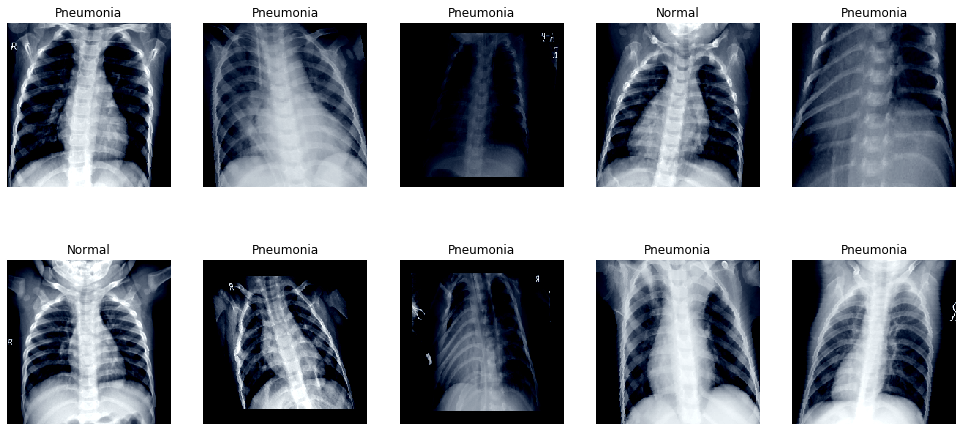

In [8]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (17, 8))
for i in np.arange(10):
    ax = fig.add_subplot(2, 5, i+1)
    plt.imshow(im_convert(images[i]), cmap = "gray")
    ax.set_title(classes[labels[i].item()])
    plt.axis("off")

# Model

Since ResNet is pretrained on ImageNet dataset which has 10 classes, we need to modify its last layer to work with our binary classification task and freeze the gradients

In [9]:
resnet = models.resnet18(pretrained = True)
for name, param in resnet.named_parameters():
    if ("bn" not in name):
        param.requires_grad = False
resnet.fc = nn.Linear(in_features = 512, out_features = 2, bias = True)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Model training

Since this is an imbalanced classification task, we need to initialize the weights for each class

In [10]:
weights = torch.FloatTensor([3533/(1187+3553), 1187/(1187+3553)]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.AdamW(resnet.parameters(), lr = 1e-4)
Metric = Metric()
scheduler = ReduceLROnPlateau(optimizer, mode = "min")
Model_History = History(type = "Binary", train_loader_len = len(training_loader), val_loader_len = len(validation_loader))
TrainingTimer = Timer()
EpochTimer = EpochTimer()

Define a function to save the model

In [11]:
def checkpoint(model, epoch):
    model_out_path = os.path.join("Pneumonia Model checkpoints", "model_epoch_{}.pth".format(epoch+1))
    torch.save(model, model_out_path)

Training loop

In [12]:
def train_model(model, optimizer, loss_function, train_loader, val_loader, num_epochs, scheduler = scheduler, device = "cuda", Metric = Metric, History = Model_History):
    TrainingTimer.start()
    for i in range(num_epochs):
        
        EpochTimer.start(i)
        Metric.reset()

        model.train()
        for batch in train_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)

            Metric.update(loss, preds, labels, phase = "Training")
        Metric.save_to_history(History, "Training")

        model.eval()
        for batch in val_loader:
            val_inputs, val_labels = batch[0].to(device), batch[1].to(device)
            val_outputs = model(val_inputs)
            val_loss = loss_function(val_outputs, val_labels)

            _, val_preds = torch.max(val_outputs, 1)

            Metric.update(val_loss, val_preds, val_labels, phase = "Validation")
        Metric.save_to_history(History, "Validation")
        scheduler.step(History.metrics["Validation"]["Accuracy"][-1])

        checkpoint(model, i)
        History.display(i)
        History.export()
        EpochTimer.end()
    
    TrainingTimer.end()

In [13]:
train_model(model = resnet, optimizer = optimizer, loss_function = criterion, train_loader = training_loader, val_loader = validation_loader, num_epochs = NUM_EPOCHS, device = device)

	 Training Loss : 0.4885
	 Training Accuracy : 0.7826
	 Training Precision : 0.9229
	 Training Recall : 0.7719
	 Training F1 : 0.8406


	 Validation Loss : 0.3582
	 Validation Accuracy : 0.8942
	 Validation Precision : 0.9332
	 Validation Recall : 0.8949
	 Validation F1 : 0.9136
						Epoch: 1 Training Time: 0:03:16
	 Training Loss : 0.2706
	 Training Accuracy : 0.9114
	 Training Precision : 0.9739
	 Training Recall : 0.9050
	 Training F1 : 0.9382


	 Validation Loss : 0.2743
	 Validation Accuracy : 0.8990
	 Validation Precision : 0.9203
	 Validation Recall : 0.9179
	 Validation F1 : 0.9191
						Epoch: 2 Training Time: 0:02:42
	 Training Loss : 0.2104
	 Training Accuracy : 0.9225
	 Training Precision : 0.9720
	 Training Recall : 0.9223
	 Training F1 : 0.9465


	 Validation Loss : 0.2546
	 Validation Accuracy : 0.9022
	 Validation Precision : 0.8964
	 Validation Recall : 0.9538
	 Validation F1 : 0.9242
						Epoch: 3 Training Time: 0:02:43
	 Training Loss : 0.1694
	 Training Accuracy :

# Evaluation

Confusion matrices of last epoch

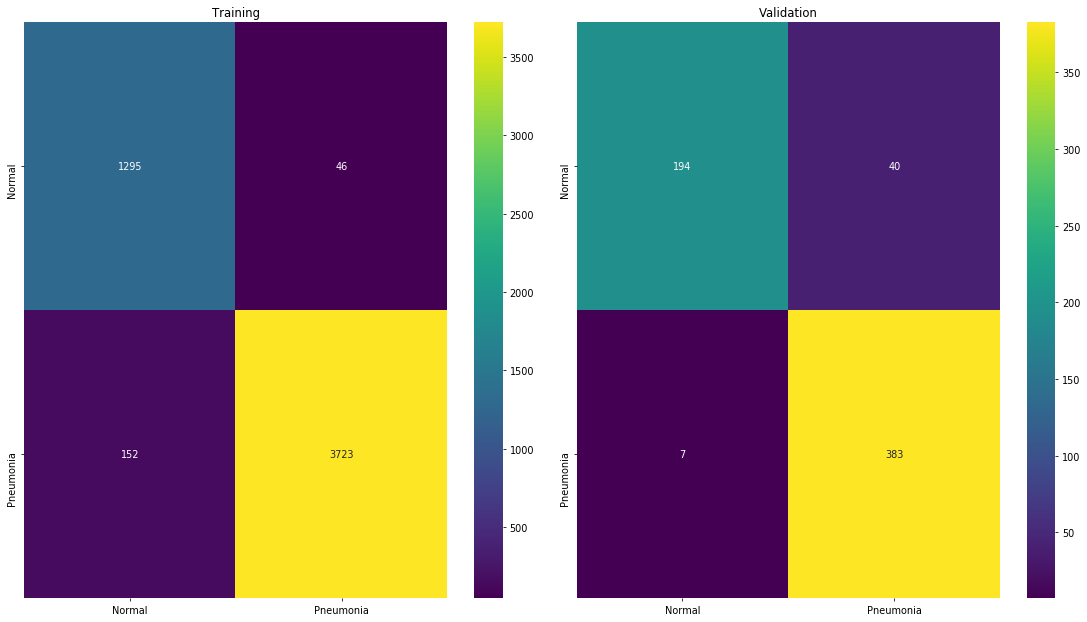

In [14]:
Analyzer.display_confusion_matrix(Model_History, classes)

Display loss and metrics

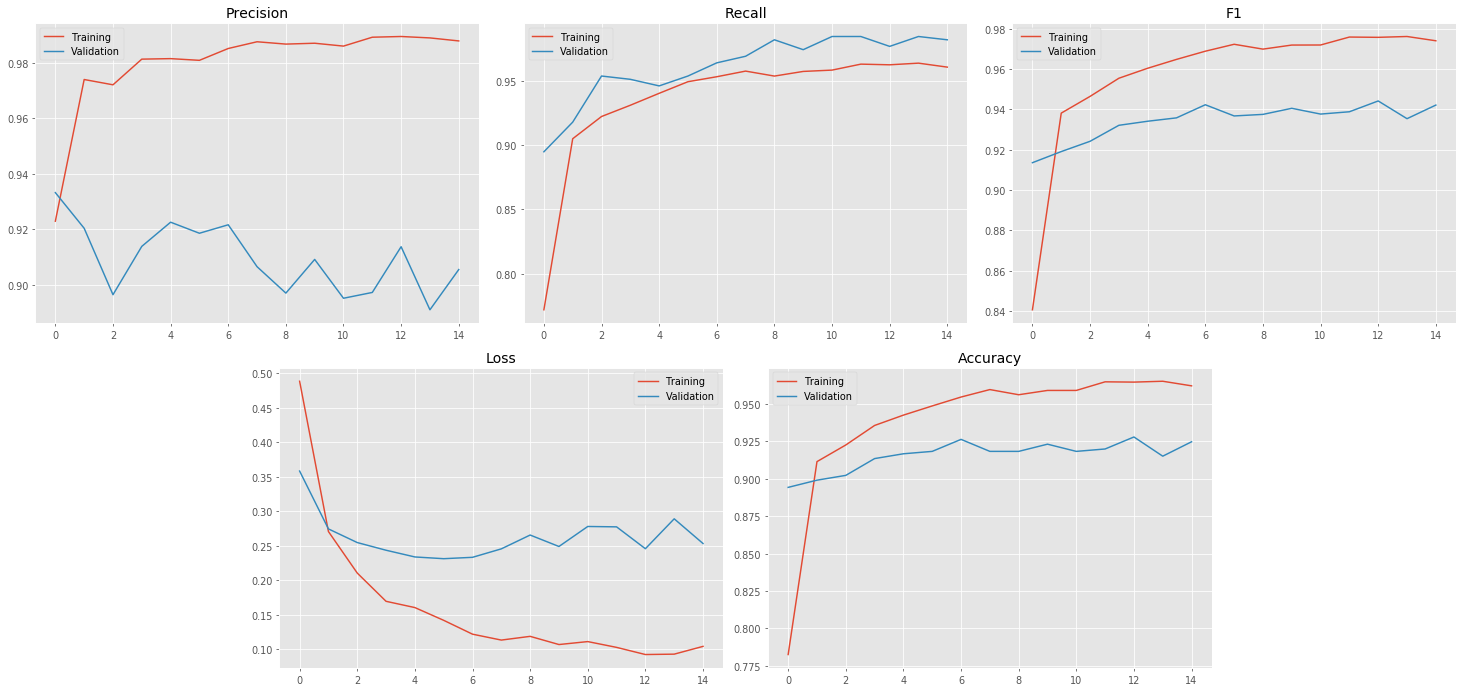

In [15]:
Analyzer.plot_binary_metrics(Model_History)

Check how the model handles validation data

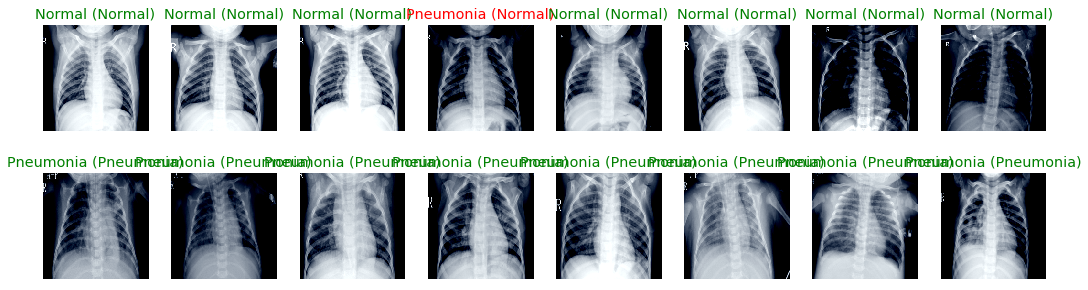

In [16]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = resnet(images)
_, preds = torch.max(output, 1)
     
fig = plt.figure(figsize=(18, 5))
for i in np.arange(16):
    ax = fig.add_subplot(2, 8, i+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[i]), cmap = "gray")
    ax.set_title("{} ({})".format(str(classes[preds[i].item()]), str(classes[labels[i].item()])), color=("green" if preds[i]==labels[i] else "red"))